# Particle Swarm Optimization

This exercise is about creating a particle swarm optimization (PSO) implementation that can solve simple 2D benchmark functions. Particle Swarm Optimization is a classical population based metaheuristic where the *candidate solutions* are defined as *particles*. Originally, PSO was inspired by bird flocking behavior where you can imagine each particle to be a bird and their behavior as a flock of birds to be the swarm that can optimize for foraging and other social behaviors. To get a basic understanding of how PSO works, in this exercise we will implement a very rudementary implentation based on the following PSO equation:



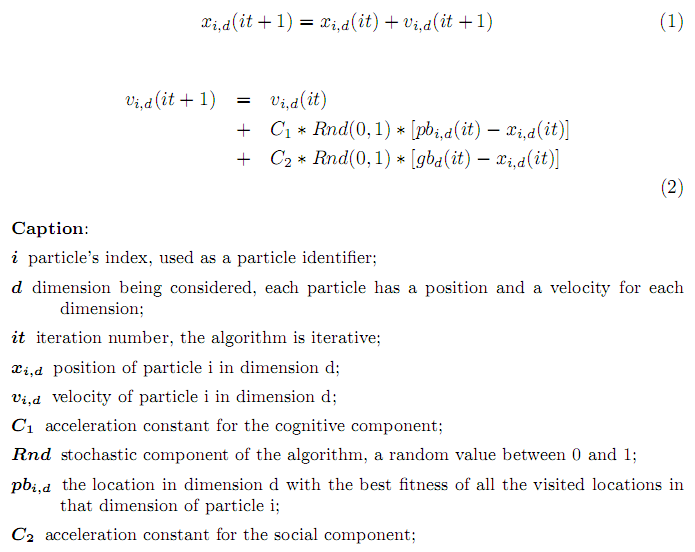

In [5]:
from IPython.display import Image 
Image("pso_equations.png") # source : http://web.ist.utl.pt/gdgp/VA/pso.htm 

Here, each particle contains parameters of its *position* and *velocity*. The first equation basically states how the position of a particle is updated based on the velocity. 
In the second, you can see how the *velocity* (v) of a particle is updated each iteration based on the best position found by a single particle (*pb*; particle's best) plus the best position of all particles (*gb*; global best). The two constants, C1 and C2 (Acceleration Constants) affect the influence of *pb* and *gb* on the velocity of the particles. With these basic equations we can start creating a PSO algorithm. 

Note that how the algorithm for this exersize is based on mostly object oriented programming and by no means will this be the most efficient way of coding the algorithm up. Feel free to enhance the implementation as you see fit. 

# Libraries

We will be using some standard libraries including some that allow us to visualize the problem space in 3D and animate it. 

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
import copy 

from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D     # 3D plotting 
from matplotlib import animation, rc        # animation
from IPython.display import HTML


### Optimization functions

Before implementing PSO, it's useful to already define the problem space. For this exercise we'll limit the problem to two dimensions and import two functions that are based on the Distributed Evolutionary Algorithms in Python (DEAP) optimization functions (https://deap.readthedocs.io/en/master/api/benchmarks.html). We'll use the Rastrigin and the Bohachevsky functions. We'll define these functions as objects with a static evaluation method that we can pass to our PSO implementation later. The evaluation functions will take in two positional coordinates (x and y) and will return a single fitness value. In addition, these functions have a lower and upper bound, so for simplicity, we'll define these parameters within the class objects as well. The functions that we are using are minimization functions so lower fitness values are better.

In [ ]:
class Rastrigin:
  lower_bound = -5.12
  upper_bound = 5.12
  @staticmethod # the evaluation function taking x and y as inputs
  def evaluate(x,y):
    return ((x**2 - 10 * np.cos(2 * np.pi * x)) + \
    (y**2 - 10 * np.cos(2 * np.pi * y)) + 20)

class Bohachevsky: 
  lower_bound = -100
  upper_bound = 100
  @staticmethod 
  def evaluate(x,y):
    return (x**2 + 2*y**2 - 0.3*np.cos(3*3.14*x) - 0.4*np.cos(4*3.14*y) + 0.7)

To visualize the two optimization functions above, we can simply create X and Y values at intervals and evaluate these X,Y coordinates as follows:

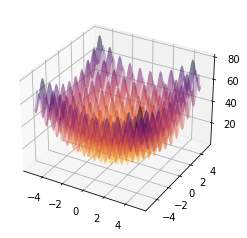

In [4]:
om = Rastrigin # Change this to Bohachevsky to see the Bohachevsky solution space (om stands for optimization method)
X = np.linspace(om.lower_bound, om.upper_bound, 100)     
Y = np.linspace(om.lower_bound, om.upper_bound, 100)     
X, Y = np.meshgrid(X, Y) 
Z = om.evaluate(X,Y)
# Our Z axis (up) will represent the fitness values for the x,y coordinates. 
fig = plt.figure() 
ax = fig.gca(projection='3d') 
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
  cmap=cm.inferno_r, linewidth=0.08,
  alpha = 0.3)    
plt.show()

### A simplified particle object

Next up we can define a simple particle object that we can update iteratively. Each particle needs to contain information about its position (*self.pos*), its velocity (*self.vel*), it's fitness (*self.fitness*), it's best position (*p_best*) and it's best fitness (*self.best_fitness*). The positional and velocity vectors are simply defined as arrays that will contain 2 values (The first referring to x, the second to y). When we create a new particle instance, we want to give it a random position and evaluate it accordingly. The *__init__* therefore takes two arguments: the random position, and a reference to the optimization function. 
For the update function, we'll use the second equation stated above. This equation requires a parameter *gb*, the best solution found in the swarm hence we'll give the update function an argument g_best every time we update it. We'll also pass the reference to the optimization function again.   

Can you write down the velocity update function correctly accepting that g_best will be a vector containing two values (x and y)?. The function requires two constants C1 and C2 which you can define globally. 

In [ ]:
class Particle:
    def __init__(self,position,optimization_function_object):
        self.pos = position
        self.vel = np.asarray([random.uniform(-VELOCITY_MAGNITUDE,VELOCITY_MAGNITUDE),random.uniform(-VELOCITY_MAGNITUDE,VELOCITY_MAGNITUDE)])
        self.p_best = copy.deepcopy(position)
        self.fitness = optimization_function_object.evaluate(self.pos[0], self.pos[1])
        self.best_fitness = self.fitness
    def update(self,g_best, optimization_function_object):
        # pick random numbers r1 and r2
        r1,r2 = random.uniform(0,1),random.uniform(0,1)
        # update particles velocity
        self.vel = 0 # Adjust this function according to the equation above. You can find a working version in the solution file. 
        # update particle's position
        self.pos = self.pos + self.vel
        # ensure position is not out of bounds
        if (self.pos[0] > optimization_function_object.upper_bound):
            self.pos[0] = optimization_function_object.upper_bound
        elif (self.pos[0] < optimization_function_object.lower_bound):
            self.pos[0] = optimization_function_object.lower_bound
        if (self.pos[1] > optimization_function_object.upper_bound):
            self.pos[1] = optimization_function_object.upper_bound
        elif (self.pos[1] < optimization_function_object.lower_bound):
            self.pos[1] = optimization_function_object.lower_bound
        # evaluate the performance of the particle
        self.fitness = optimization_function_object.evaluate(self.pos[0],self.pos[1])
        # If a better solutions has been found, the best_fitness and best position should be updated.
        if (self.fitness < self.best_fitness):
            self.best_fitness = self.fitness
            self.p_best = copy.deepcopy(self.pos)
        

### A simplified swarm object

To encapsulate the individual particles, we can create a swarm object (the equavalent in evolutionary algorithms being a population). I have chosen to store the particles in a simple array and the reference to the optimization_function is stored in the instance as well. When creating a swarm, we pass an argument of the number of particles we want to simulate, and the optimization function we are using. To get the best particle in the swarm so far, we can simply iterate over all particles and keep track of which one is the best. 


In [ ]:
class Swarm:
    def __init__(self,n_particles, optimization_function):
        self.particles = []
        self.optimization_function = optimization_function
        for i in range(n_particles):
            # Initialize a random positional vector within the scope
            LB = self.optimization_function.lower_bound
            UB = self.optimization_function.upper_bound
            pos = np.asarray([random.uniform(LB,UB),random.uniform(LB,UB)])
            # Having a random.uniform distribution is perhaps a bit too easy to optimize. See what happens if you initialize particles in different parts of the search space: 
            # pos = np.asarray([random.uniform(LB,LB+2),random.uniform(LB,LB+2)])
            # create a new particle instance
            p = Particle(pos, self.optimization_function)
            self.particles.append(p)
        self.g_best = None
        self.min_fit = 10000.0 # give a high value to the best solution initially so it will be overwritten
        self.best(self.particles) # adjusts self's g_best and min_fit
        
    def best(self, particles, minimization = True):
        # This is quite a hacky function and simply sets the g_best (position of the best particle value) if a new best fitness (min_fit) is found.
        for p in particles:
            if (p.fitness < self.min_fit):
                self.min_fit = p.fitness
                self.g_best = copy.deepcopy(p.p_best)
        
    def update(self):
        positions = []
        fitness_values = []
        for p in self.particles:
            p.update(self.g_best, self.optimization_function)
            positions.append(p.pos)
            fitness_values.append(p.fitness)
        self.best(self.particles)
        return positions,fitness_values
        


### Running the algorithm

We are using some variables in our update functions that aren't defined yet so we'll start of by defining them globally. We need to define the acceleration coefficients (C1 and C2), and the *VELOCITY_MAGNITUDE*. 

In [ ]:
C1 = 0.001 # acceleration coefficient 1
C2 = 0.04 # acceleration coefficient 2
VELOCITY_MAGNITUDE = 0.0

Now we can create and run the PSO method by creating a new swarm obect and calling the update function a few times. 

In [ ]:
swarm = Swarm(50, Rastrigin) # the first argument sets the number of particles we are using, the second is the reference to the objective function
for i in range(50):
    swarm.update()
    print(swarm.min_fit) # we can print the best solution found so far to ensure our algorithm is working

If you're like me, seeing the optimization algorithm working as above is not very insightful to understand how it works. To help us get a better understanding of how the algorithm traverses the search space, we can make a small animation using matplotlib that updates the X,Y and Z values of each particle by iterating through it. We can create a new swarm and update it accordingly while at the same time plotting the animation. 

In [ ]:
om = Rastrigin # Change this to Bohachevsky to see the Bohachevsky solution space

# create a new PSO swarm
swarm = Swarm(50, om)

# To plot the landscape
X = np.linspace(om.lower_bound, om.upper_bound, 100)     
Y = np.linspace(om.lower_bound, om.upper_bound, 100)     
X, Y = np.meshgrid(X, Y) 
Z = om.evaluate(X,Y)

fig = plt.figure() 
ax = fig.gca(projection='3d') 

LB = swarm.optimization_function.lower_bound
UB = swarm.optimization_function.upper_bound

def update(frame, print_best = False):    
    ax.clear()
    position_values_x = []
    position_values_y = []
    positions, fitnesses = swarm.update()
    for pos in positions:
        position_values_x.append(pos[0])
        position_values_y.append(pos[1])
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.inferno, linewidth=0.08, alpha = 0.1)
    ax.set_xlim(LB,UB)
    ax.set_ylim(LB,UB)
    ax.set_zlim(0.0,np.amax(Z))
    ax.scatter(position_values_x, position_values_y,fitnesses,c=fitnesses)
    if print_best:
        print("Highest fitness is " ,swarm.max_fit, " at ", swarm.g_best)

n_iterations = 50 # the number of iterations
interval = 20 # 
anim = animation.FuncAnimation(fig, update, frames=np.arange(n_iterations), interval=interval)
HTML(anim.to_jshtml())